In [48]:
import os
import cv2
from PIL import Image
import numpy as np
from wordsegmentation.WordSegmentation import *

In [117]:
#path='/root/WordSegmentationRecognitionPipeline/src/Inputs/'+'twolines.jpg'
path='/root/WordSegmentationRecognitionPipeline/src/Inputs/'+'Hello World Good Morning.jpg'
#path='/root/WordSegmentationRecognitionPipeline/src/Inputs/'+'Hello World Small.jpg'
#path='/root/WordSegmentationRecognitionPipeline/src/Inputs/'+'sentences.jpg'
#path='/root/WordSegmentationRecognitionPipeline/src/Inputs/'+'handwritten long.jpg'

In [118]:
cv2.THRESH_BINARY

0

In [132]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
 
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
 
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
 
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
 
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
	# return the warped image
	return warped

In [196]:
def preprocess(gray):
    # 1. Sobel算子，x方向求梯度
    sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, ksize = 3)
    # 2. 二值化
    ret, binary = cv2.threshold(sobel, 200, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY) # second 0
    #binary=255-gray
    # 3. 膨胀和腐蚀操作的核函数
    element1 = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 9))
    element2 = cv2.getStructuringElement(cv2.MORPH_RECT, (24, 6))
 
    # 4. 膨胀一次，让轮廓突出
    dilation = cv2.dilate(binary, element2, iterations = 2) #1
 
    # 5. 腐蚀一次，去掉细节，如表格线等。注意这里去掉的是竖直的线
    erosion = cv2.erode(dilation, element1, iterations = 1)
 
    # 6. 再次膨胀，让轮廓明显一些
    dilation2 = cv2.dilate(erosion, element2, iterations = 3)
 
    # 7. 存储中间图片 
    cv2.imwrite("binary.png", binary)
    cv2.imwrite("dilation.png", dilation)
    cv2.imwrite("erosion.png", erosion)
    cv2.imwrite("dilation2.png", dilation2)
 
    return dilation2
def findTextRegion(img):
    region = []
 
    # 1. 查找轮廓
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
 
    # 2. 筛选那些面积小的
    for i in range(len(contours)):
        cnt = contours[i]
        # 计算该轮廓的面积
        area = cv2.contourArea(cnt) 
 
        # 面积小的都筛选掉
        if(area < 2000):
            continue
 
        # 轮廓近似，作用很小
        epsilon = 0.001 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
 
        # 找到最小的矩形，该矩形可能有方向
        rect = cv2.minAreaRect(cnt)
        #print "rect is: "
        #print rect
 
        # box是四个点的坐标
        box = cv2.boxPoints(rect)
        box = np.int0(box)
 
        # 计算高和宽
        height = abs(box[0][1] - box[2][1])
        width = abs(box[0][0] - box[2][0])
 
        # 筛选那些太细的矩形，留下扁的
        if(height > width * 1.2):
            continue
 
        region.append(box)
 
    return region
def detect(img):
    image_list=[]
    # 1.  转化成灰度图
    img_copy=img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     
    # 2. 形态学变换的预处理，得到可以查找矩形的图片
    dilation = preprocess(gray)
 
    # 3. 查找和筛选文字区域
    region = findTextRegion(dilation)
    #region=non_max_suppression_merge(region)
 
    # 4. 用绿线画出这些找到的轮廓
    for box in region:
        cv2.drawContours(img_copy, [box], 0, (0, 255, 0), 2)
        #print(box)
        image_list.append(four_point_transform(img,box))
    return img_copy, image_list
#    cv2.namedWindow("img", cv2.WINDOW_NORMAL)
#    cv2.imshow("img", img)
 
    # 带轮廓的图片
#    cv2.imwrite("contours.png", img)
 
#    cv2.waitKey(0)
#    cv2.destroyAllWindows()


In [197]:
boxes[0].shape

(4, 2)

In [198]:
img.shape

(1440, 1080, 3)

In [199]:
img=cv2.imread(path)

In [203]:
img_dtct,img_list=detect(img)

In [201]:
small.min()


39

In [206]:
small=img_list[0]#cv2.cvtColor(four_point_transform(img,boxes[0]), cv2.COLOR_BGR2GRAY)

In [216]:
n=0
h,w,_=img_list[2].shape
print(w/h)

2.267123287671233


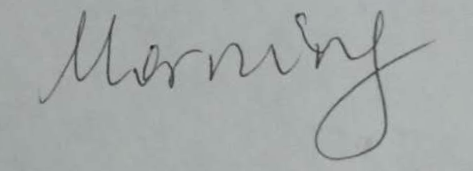

In [208]:
Image.fromarray(small)

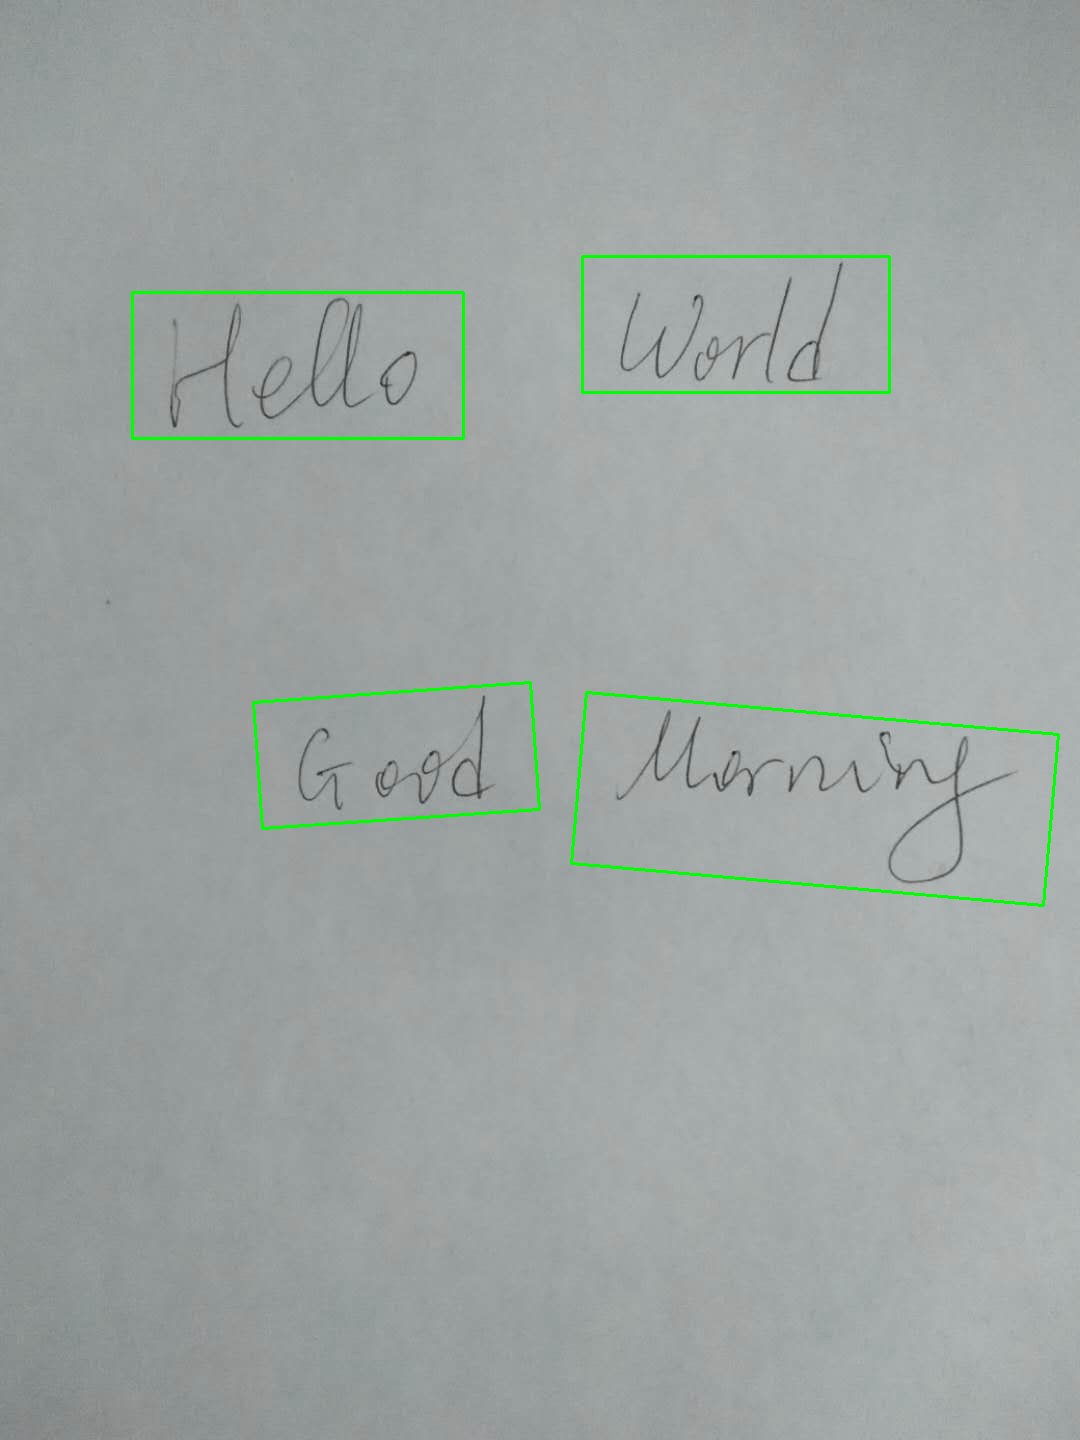

In [209]:
Image.fromarray(img_dtct)